In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import moseq2_viz
from moseq2_viz.util import parse_index
from moseq2_viz.model.util import (get_transition_matrix,
                                   parse_model_results,
                                   results_to_dataframe,
                                   relabel_by_usage, get_syllable_statistics)
from sentence_transformers import SentenceTransformer, models, InputExample, datasets
from tqdm.notebook import tqdm
import seaborn as sns
import pdb
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='4'

In [2]:
super_dir = '/media/data_cifs/matt/abraira_data'
experiment = '2021-02-19_Meloxicam'
if experiment == '2021-02-19_Meloxicam':
    model_file = os.path.join(super_dir, experiment, 'rST_model_1000.p')
    index_file = os.path.join(super_dir, experiment, 'moseq2-index.role.yaml')
    max_syllable = 66
    groups = ['baseline', '4hrs carrageenan', '24hrs saline', '24hrs meloxicam', 'baseline meloxicam']
elif experiment == '2020-11-10_Celsr3-R774H':
    model_file = os.path.join(super_dir, experiment, 'robust_septrans_model_1000.p')
    index_file = os.path.join(super_dir, experiment, 'gender-genotype-index.yaml')
    max_syllable = 66
    groups = ['F_+/+', 'F_RH/RH', 'F_+/RH', 'M_+/+', 'M_RH/RH', 'M_+/RH']
elif experiment == 'SstCre_Celsr3CKO':
    model_file = os.path.join(super_dir, experiment, 'robust_septrans_model_20min_1000.p')
    index_file = os.path.join(super_dir, experiment, 'moseq2-index.sex-genotype.20min.yaml')
    max_syllable = 66
    groups = ['F_+/+;Celsr3^f/f', 'F_Sst-Cre/+;Celsr3^f/f', 'M_Sst-Cre/+;Celsr3^f/f', 'M_+/+;Celsr3^f/f']
palette = sns.color_palette(['#f06493', '#35fab3', '#647aa3', '#020887', '#ff0000'])


In [4]:
_, sorted_index = parse_index(index_file)
ms_model = parse_model_results(model_file, sort_labels_by_usage=True, count='usage')

labels = ms_model['labels']
label_group = [sorted_index['files'][uuid]['group'] for uuid in ms_model['keys']]
tm_vals = []
group_vals = []
group_labels = []
usage_vals = []
frames_vals = []
syllables_vals = []
sentences_vals = []
bad_syllables = [-5]

for l, g, u in tqdm(list(zip(labels, label_group, ms_model['keys'])), leave=False):
    if g in groups:
        group_vals.append(g)
        group_labels.append(groups.index(g))
        
        tm = get_transition_matrix([l], combine=True, max_syllable=max_syllable)
        tm_vals.append(tm.ravel())
        
        u, _ = get_syllable_statistics(l, count='usage')
        total_u = np.sum(list(u.values()))
        usage_vals.append(np.array(list(u.values())) / total_u)
        
        f, _ = get_syllable_statistics(l, count='frames')
        total_f = np.sum(list(f.values()))
        frames_vals.append(np.array(list(f.values())) / total_f)

        l = list(filter(lambda a: a not in bad_syllables, l))
        np_l = np.array(l)
        cp_inds = np.concatenate((np.where(np.diff(np_l) != 0 )[0],np.array([len(l) - 1])))
        syllables = np_l[cp_inds]
        syllables_vals.append(syllables)
        sentence = [str(syl) for syl in syllables]
        sentences_vals.append(' '.join(sentence))

#tm_vals
usage_vals = np.array(usage_vals)
frames_vals = np.array(frames_vals)
#usage_vals
num_animals = len(syllables_vals)

train_prop = .8
train_sentences = sentences_vals[:int(train_prop*num_animals)]
test_sentences = sentences_vals[int(train_prop*num_animals):]
num_train = len(train_sentences)
num_test = num_animals - num_train

In [ ]:
with open(os.path.join(super_dir, experiment, experiment + '.txt'), 'w') as f: 
    f.write('\n'.join([sentence for sentence in sentences_vals]))  # write lines with '#' appended

In [5]:
train_examples = []
# num_animals = len(syllables_vals)

with tqdm(total=num_train**2 - num_train) as pbar:
    for i, sentence1 in enumerate(train_sentences):
        for j, sentence2 in enumerate(train_sentences):
            if i == j: 
                continue
            else:
                texts = [sentence1, sentence2]
                label = 1.0*(group_vals[i] == group_vals[j])
            train_examples.append(InputExample(texts=texts, label=label))
            pbar.update(1)

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=8)
# train_dataloader = DataLoader(train_examples[:int(.8*len(train_examples))], shuffle=True, batch_size=8)

In [5]:
# Create the special denoising dataset that adds noise on-the-fly
noisy_data = datasets.DenoisingAutoEncoderDataset(sentences_vals)

# DataLoader to batch your data
noisy_dataloader = DataLoader(noisy_data, batch_size=8, shuffle=True)

In [6]:
double_data = [InputExample(texts=[s, s]) for s in sentences_vals]
double_dataloader = DataLoader(double_data, batch_size=8, shuffle=True)

In [19]:
device='cuda'
model_name = 'bert-base-uncased'
word_embedding_model = models.Transformer(model_name, max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=70, activation_function=torch.nn.Tanh())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model], device=device)
# pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
# model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
from sentence_transformers import losses
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

loss_type = 'semisupervised' # 'unsupervised1', 'unsupervised2'

if loss_type == 'semisupervised':
    train_loss = losses.CosineSimilarityLoss(model)

    #Tune the model
    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100)
elif loss_type == 'unsupervised1':

    train_loss = losses.DenoisingAutoEncoderLoss(model, decoder_name_or_path=model_name, tie_encoder_decoder=True)

    # Call the fit method
    model.fit(
        train_objectives=[(noisy_dataloader, train_loss)],
        epochs=10,
        weight_decay=0,
        scheduler='constantlr',
        optimizer_params={'lr': 3e-5},
        show_progress_bar=True
    )
elif loss_type == 'unsupervised2':

    # Use the denoising auto-encoder loss
    train_loss = losses.MultipleNegativesRankingLoss(model)

    # Call the fit method
    model.fit(
        train_objectives=[(double_dataloader, train_loss)],
        epochs=1,
        weight_decay=0,
        scheduler='constantlr',
        optimizer_params={'lr': 1e-3},
        show_progress_bar=True
    )


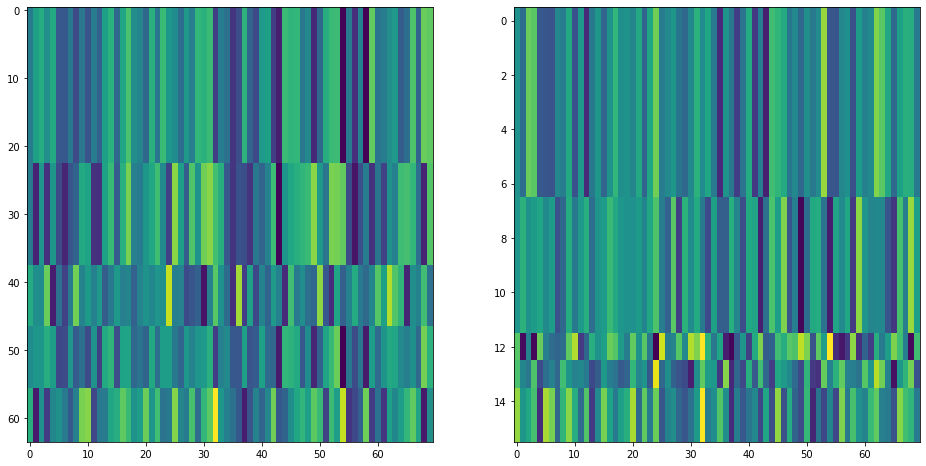

In [21]:
import matplotlib.pyplot as plt
train_embeddings = model.encode(train_sentences)
test_embeddings = model.encode(test_sentences)

np_g = np.array(group_labels)
train_labels = np_g[:num_train]
test_labels = np_g[num_train:]

fig, axes = plt.subplots(1,2,figsize=(16,8))

for ax, em, lb in zip(axes,[train_embeddings, test_embeddings], [train_labels, test_labels]): 
    lb_ind = np.argsort(lb)
    lb = lb[lb_ind]
    ax.imshow(em[lb,:])
    ax.set_aspect('auto')
plt.show()
plt.close()

In [22]:
from sklearn.linear_model import LogisticRegression
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

C = 5e-2 #5e-2
accs = []

for i, (em, lb) in enumerate(zip([train_embeddings, test_embeddings],[train_labels, test_labels])):

    perm_ind = np.random.permutation(len(em))
    perm_embeddings = em[perm_ind,:]
    perm_labels = np.array(lb)[perm_ind]

    if i < 1:
        clf = LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial',C=C).fit(perm_embeddings, perm_labels)
    y_pred = clf.predict(em)
    print(np.mean(1*(y_pred==perm_labels)))

0.28125
0.3125


In [66]:
from sklearn.linear_model import LogisticRegression
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

K = 1
perm_ind = np.random.permutation(num_animals)
perm_embeddings = sentence_embeddings[perm_ind,:]
perm_labels = np.array(group_labels)[perm_ind]

C = 5e-2 #5e-2
accs = []

for i in tqdm(range(int(num_animals / float(K)))):
    
    shifted_embeddings = np.roll(perm_embeddings, i*K, axis=0)
    shifted_labels = np.roll(perm_labels, i*K, axis=0)

    train_X, train_y = shifted_embeddings[K:,:], shifted_labels[K:]
    test_X, test_y = shifted_embeddings[:K,:], shifted_labels[:K]

    clf = LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial',C=C).fit(train_X, train_y)
    y_pred = clf.predict(test_X)
    accs.append(np.mean(1*(y_pred == test_y)))
print(np.mean(accs))


0.375
